# Energy Load Prediction Using TensorFlow


## Preparations

In [1]:
# Install necessary packages
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras import layers




In [2]:
# Enable GPU and check availability
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

# Allow TensorFlow to use all available GPU memory
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPU is available


In [3]:
# Connect to Google Drive to get access to the dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load dataset

dfo = pd.read_csv('/content/drive/MyDrive/merged_cleaned.csv', names=["time", "load", "price", "biomass", "water", "offshore", "onshore", "solar", "other_renewable", "nuclear", "lignite", "coal", "gas", "pumped", "other_conv", "holiday", "date", "hour", "dayofweek", "day_name", "quarter", "month", "year", "dayofyear", "dayofmonth", "date_offset", "hour_sin", "hour_cos", "dayofweek_sin", "dayofweek_cos", "month_sin", "month_cos", "dayofyear_sin", "dayofyear_cos", "is_workday"], header=0)



In [5]:


# Remove non-numeric columns (e.g., timestamp)
# To avoid changing the original dataframe dfo, we copy it
df = dfo.copy()

df = df.drop(columns=['time'])
df = df.drop(columns=['date'])
df = df.drop(columns=['day_name'])

#adapt column "holiday", so only 0 for Not a Holiday and 1 for any holidays is used
df["holiday"] = df["holiday"].apply(lambda x: 0 if x == "Not a Holiday" else 1)

# Now separate the target and non-numeric columns from the features
target = 'load'
features = df.drop(columns=[target])

# Normalize/Scale the features
scaler = MinMaxScaler()

scaled_features = scaler.fit_transform(features)
#scaled_features = features

# Scale the target
#scaled_target = scaler.fit_transform(df[[target]])
scaled_target = df[[target]]



In [8]:

# Split into train and test sets
# 0.83296 is the value, that splits the datasets between October 31st 2023 and November 1st 2023, which is the line between our training and test data.
train_size = int(len(X) * 0.83296)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Define Training

In [7]:
# Create rolling window

# Function to create sequences for time series prediction
def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])  # Use the last `sequence_length` timesteps as features
        y.append(target.iloc[i,0])  # Target value for the next timestep
    return np.array(X), np.array(y)

# Adjust sequence length. How many timesteps shall be used for training?
sequence_length = 170  # Use x timesteps to predict the next value

#
# Forecast horizon: How many time steps ahead in the future do you want to predict?
# Adjust as desired
#
forecast_horizon = 12  # Predict x hour(s) ahead
X, y = create_sequences(scaled_features, scaled_target, sequence_length)

The forecast horizon is crucial, since we want to predict useful values for the future to prepare the charging and discharging of Battery Energy Storage Systems. We tried different forecast horizons, from 1 to 12 hours. The results did not differ very much

In [13]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

# Function to get angles for positional encoding
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

# Function to generate positional encoding
def get_positional_encoding(sequence_length, d_model):
    position = np.arange(sequence_length)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rads = get_angles(position, i, d_model)
    pos_encoding = angle_rads[np.newaxis, ...]  # Add a batch dimension
    return tf.cast(pos_encoding, dtype=tf.float32)

# Define the model
def create_transformer_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Generate the positional encoding
    pos_encoding = get_positional_encoding(input_shape[0], input_shape[1])  # Generate for sequence_length and d_model

    # Add positional encoding to inputs
    inputs_with_pos = inputs + pos_encoding[:, :input_shape[0], :]  # Add positional encoding aligned to the input

    # Transformer block (MultiHeadAttention expects 3D inputs)

    #
    # You can change the number of attention heads and their dimension
    #
    transformer_block = layers.MultiHeadAttention(num_heads=8, key_dim=64)(inputs_with_pos, inputs_with_pos)
    transformer_block = layers.Dropout(0.1)(transformer_block)
    transformer_block = layers.LayerNormalization(epsilon=2e-6)(transformer_block)

    # Feedforward network with ReLU activation
    feed_forward = layers.Dense(64, activation='relu')(transformer_block)

    # Output layer with no activation (linear) for regression
    output = layers.Dense(1)(feed_forward)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=output)

    # Compile the model
    #
    # You can pick a different optimizer, loss or metrics.
    # We tried "mse" and "huber_loss" as losses and "mae" and "mape" as metrics
    #
    model.compile(optimizer='adam', loss='huber_loss', metrics=['mape'])

    return model

# Example input shape: (batch_size, sequence_length, d_model)
# Ensure X_train has shape (samples, sequence_length, features) where features is usually 1 for time series prediction
model = create_transformer_model(X_train.shape[1:])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1, 31)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 31)          │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 1, 31)          │         65,055 │ add[0][0], add[0][0]   │
│ (MultiHeadAttention)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1, 31)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 1, 31)          │             62 │ dropout_1[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 64)          │          2,048 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1)           │             65 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 67,230 (262.62 KB)

 Trainable params: 67,230 (262.62 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [26]:
%%time

# Train the Model

history = model.fit(X_train, y_train, epochs=5, batch_size=1, validation_data=(X_test, y_test))

Epoch 1/5
43829/43829 ━━━━━━━━━━━━━━━━━━━━ 137s 3ms/step - loss: 6828511.0000 - mape: 3.7905 - val_loss: 6563243.5000 - val_mape: 3.8880
Epoch 2/5
43829/43829 ━━━━━━━━━━━━━━━━━━━━ 136s 3ms/step - loss: 6487071.5000 - mape: 3.6883 - val_loss: 6448627.0000 - val_mape: 3.8288
Epoch 3/5
43829/43829 ━━━━━━━━━━━━━━━━━━━━ 130s 3ms/step - loss: 6406281.5000 - mape: 3.6627 - val_loss: 6972805.0000 - val_mape: 3.9228
Epoch 4/5
43829/43829 ━━━━━━━━━━━━━━━━━━━━ 135s 3ms/step - loss: 6369702.5000 - mape: 3.6445 - val_loss: 6648441.5000 - val_mape: 3.9068
Epoch 5/5
43829/43829 ━━━━━━━━━━━━━━━━━━━━ 141s 3ms/step - loss: 6186758.0000 - mape: 3.6026 - val_loss: 6347463.0000 - val_mape: 3.7907
CPU times: user 11min 56s, sys: 51.8 s, total: 12min 47s
Wall time: 11min 26s


## Evaluation

In [27]:
# Evaluate the Model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 106075376.0000 - mape: 14.9841
Test Loss: 97209392.0, Test MAE: 14.963336944580078


In [28]:
# Make Predictions
predictions = model.predict(X_test)

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [29]:
# Reverse scaling
predictions = predictions.reshape(-1, 1)
#predictions_rescaled = scaler.inverse_transform(predictions)
#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [30]:
# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"Test MAPE: {mape * 100:.2f}%")  # Multiply by 100 to express MAPE as a percentage


Test MAPE: 3.79%


In [31]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"Test MAE: {mae:.2f}")  # The MAE is the average of absolute differences

Test MAE: 1963.17


We tried different combinations of hyper-parameters (epochs, batch size, learning rate, number of attention heads, size of attention heads, loss, metrics). In most cases, the results were quite similar (between MAPE of 3% and 5%).

### Plot the results

<ipython-input-32-a740fafd5adf>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(y_test), freq='H')


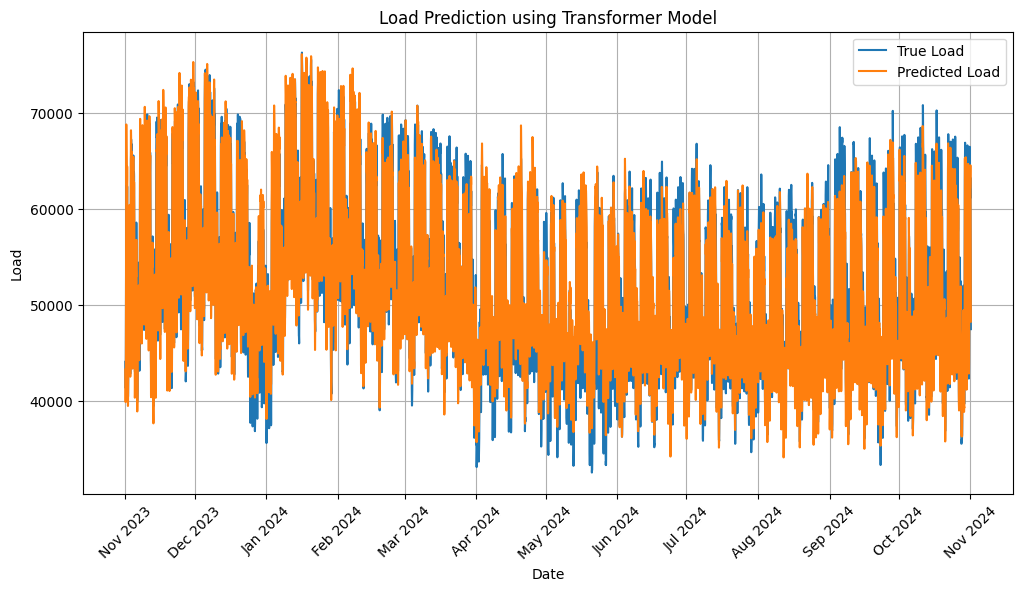

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a date range for the test data, starting from November 1st, 2023 with hourly data
start_date = '2023-11-01'
date_range = pd.date_range(start=start_date, periods=len(y_test), freq='H')

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(date_range, y_test, label='True Load')
plt.plot(date_range, predictions, label='Predicted Load')

# Set x-ticks for the start of every month
month_starts = pd.date_range(start=start_date, end=date_range[-1], freq='MS')  # 'MS' gives the first day of every month
plt.xticks(month_starts, month_starts.strftime('%b %Y'), rotation=45)  # Format as month-year (e.g., Nov 2023)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Load')
plt.legend()
plt.title('Load Prediction using Transformer Model')
plt.grid(True)

# Display the plot
plt.show()


<ipython-input-33-ae8f971d2b07>:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=168, freq='H')


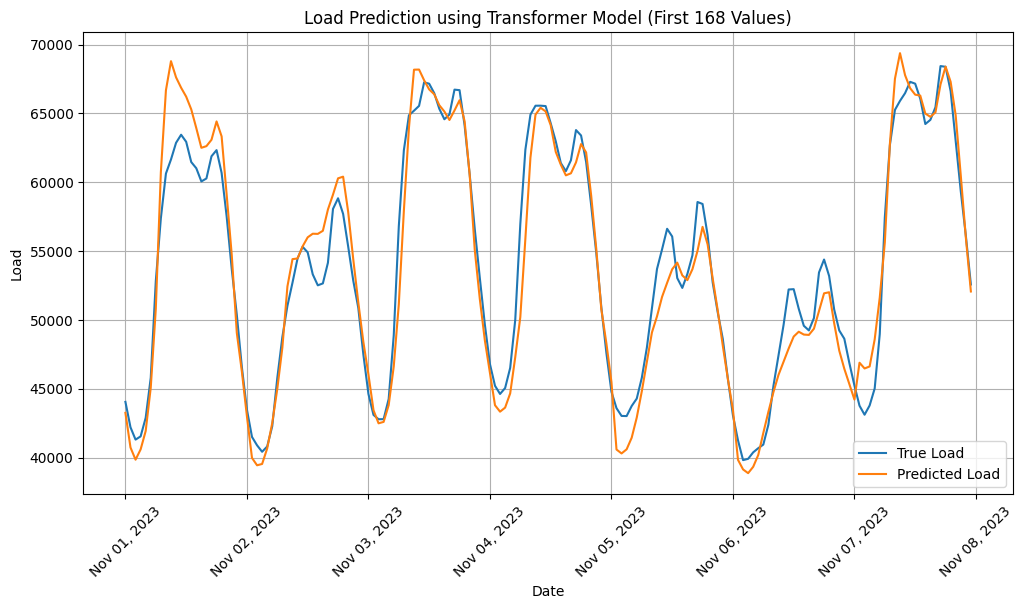

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Slice the first 168 values (7 days, 24 hours per day) of the test data
y_test_subset = y_test[:168]
predictions_subset = predictions[:168]

# Create a date range starting from November 1st, 2023 with hourly frequency
start_date = '2023-11-01'
date_range = pd.date_range(start=start_date, periods=168, freq='H')

# Visualize the results for the first 168 values
plt.figure(figsize=(12, 6))
plt.plot(date_range, y_test_subset, label='True Load')
plt.plot(date_range, predictions_subset, label='Predicted Load')

# Set x-ticks for each day (every 24 hours)
day_starts = pd.date_range(start=start_date, periods=8, freq='D')  # Start of each day in the first week
plt.xticks(day_starts, day_starts.strftime('%b %d, %Y'), rotation=45)  # Format as "Nov 01, 2023"

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Load')
plt.legend()
plt.title('Load Prediction using Transformer Model (First 168 Values)')
plt.grid(True)

# Display the plot
plt.show()


The predictions show the typical patterns of the dataset. The model does a pretty good job, even though the results are a bit off sometimes.

### Save the model

In [34]:

# Save the model on Google Drive
model.save('/content/drive/MyDrive/tensorflow_model-002.keras')
